In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [44]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-Data/raw/main/CA06/Mall_Customers.csv')

### Data Exploration

First we check if there are any missing values in the dataset.

In [45]:
missing_values = df.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


There are no missing values. Now let's check the distributions of our different columns.

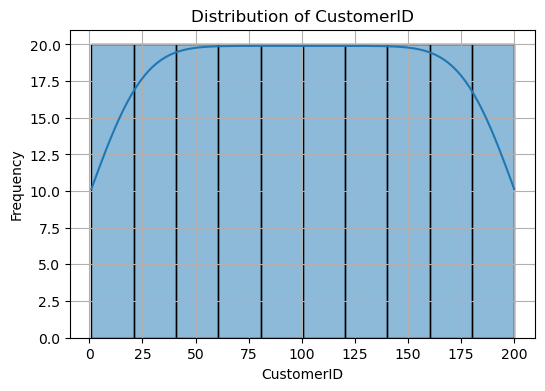

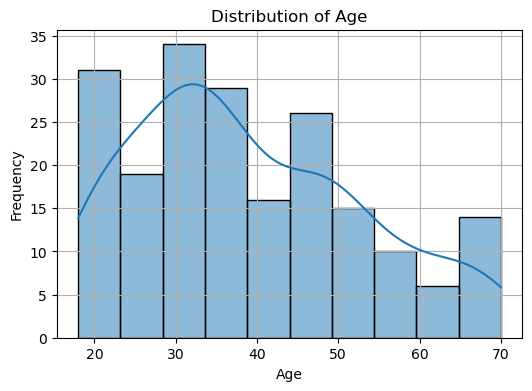

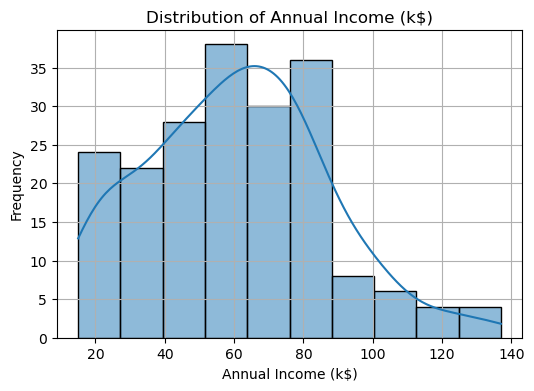

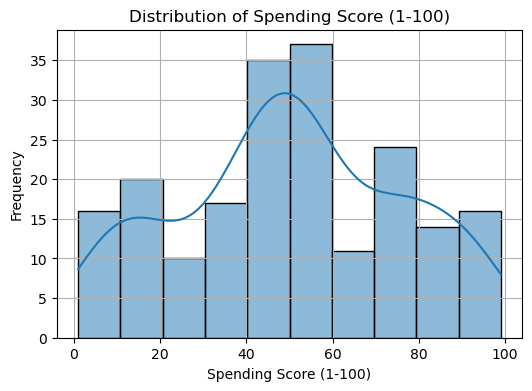

In [46]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Both age and income seem to be right skewed. Spending score seems to be relatively normally distributed.

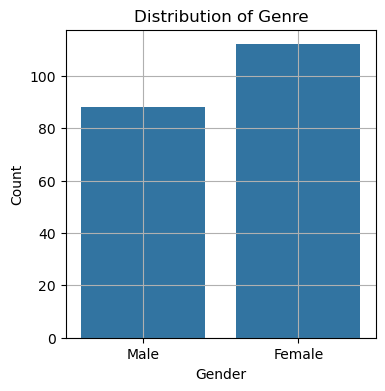

In [47]:
# Plot categorical column (Gender)
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='Genre')
plt.title('Distribution of Genre')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Our only categorical feature is gender. We have more female than male but the imbalance isn't too large.

### Data Cleaning & Transformation

First we label encode gender.

In [48]:
le = LabelEncoder()
df['Gender_encoded'] = le.fit_transform(df['Genre'])

Now we split into continous and categorical in preperation for scaling.

In [50]:
X_continuous = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_categorical = df[['Gender_encoded']]

Next we apply a standard scaler to our continous features

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_continuous)

Now we concatenate our scaled continous features and categoricals and convert to a dataframe

In [52]:
X_cluster_ready = np.concatenate([X_scaled, X_categorical], axis=1)

In [53]:
df_clustering = pd.DataFrame(X_cluster_ready, columns=['Age', 'Annual Income', 'Spending Score', 'Gender_encoded'])

Now we have our final df for clustering

In [54]:
df_clustering.head()

,Age,Annual Income,Spending Score,Gender_encoded
0,-1.424569,-1.738999,-0.434801,1.0
1,-1.281035,-1.738999,1.195704,1.0
2,-1.352802,-1.700830,-1.715913,0.0
3,-1.137502,-1.700830,1.040418,0.0
4,-0.563369,-1.662660,-0.395980,0.0


We're going to start with clustering by annual income and spending score

In [55]:
df_clustering_subset = df_clustering[['Annual Income', 'Spending Score']]

### Clustering

Before we run the clustering algorithm we need to find the optimal value for k. We will be using the silhoutte method for this.

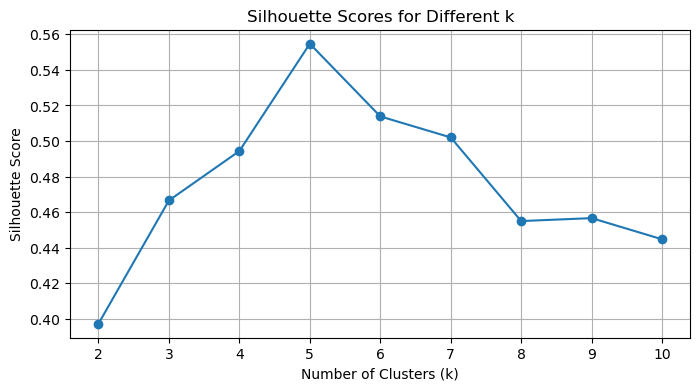

Optimal number of clusters (k) based on silhouette score: 5


In [56]:
silhouette_scores = []
k_range = range(2, 11)  # Try k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df_clustering_subset)
    score = silhouette_score(df_clustering_subset, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Best number of clusters
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (k) based on silhouette score: {best_k}")

As we see in both the graph and the outputted value, 5 is the optimal value for k. Now let's apply this to the algorithm.

In [61]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(df_clustering_subset)

Now we apply our clusters back to our original dataset.

In [62]:
df['Cluster'] = cluster_labels

Now let's visualize our clusters

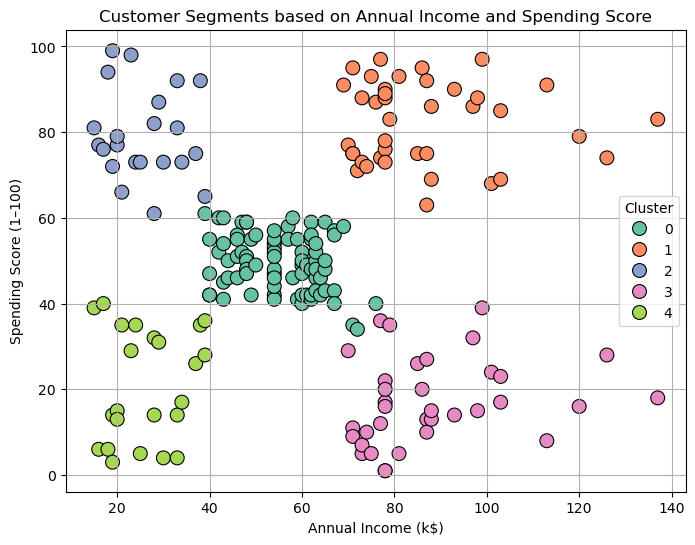

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use unscaled features for easier interpretation in the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette='Set2',
    s=100,
    edgecolor='k'
)
plt.title('Customer Segments based on Annual Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


Visually the clusters seem to be fairly distinct with little over lap. Although some lack compactness there is still decent seperation. These seem to be good quality clusters. Now let's analyze the clusters by looking at the average values.

In [71]:
numeric_summary = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
gender_counts = df.groupby(['Cluster', 'Genre'])['CustomerID'].count().unstack().fillna(0)
cluster_summary = numeric_summary.join(gender_counts, how='left')
cluster_summary.columns.name = None 
print(cluster_summary)

               Age  Annual Income (k$)  Spending Score (1-100)  Female  Male
Cluster                                                                     
0        42.716049           55.296296               49.518519      48    33
1        32.692308           86.538462               82.128205      21    18
2        25.272727           25.727273               79.363636      13     9
3        41.114286           88.200000               17.114286      16    19
4        45.217391           26.304348               20.913043      14     9


***Cluster Interpretation:***

Cluster 1: Middle-aged, middle-income, moderate spenders, slightly more female — Balanced consumers, likely stable and practical. They might respond well to mainstream offerings and loyalty programs.

Cluster 2: Young, high-income, high spenders, balanced gender-wise — Prime targets for premium products, lifestyle brands, and aspirational marketing. Likely urban professionals.

Cluster 3: Young, low-income, high spenders, more female — Possibly students or trend-conscious young adults spending heavily. Responsive to social marketing, discounts, and experiences.

Cluster 4: Affluent but low spenders, balanced gender — Middle-aged and high-income but conservative with spending. Might need value-based or trust-building strategies.

Cluster 5: Older, low-income, frugal consumers, more female — Possibly retired or cautious spenders with limited disposable income. Budget-friendly products and essential services would resonate best here.

### Bonus Clustering

Let's cluster on all our features to see how the results differ

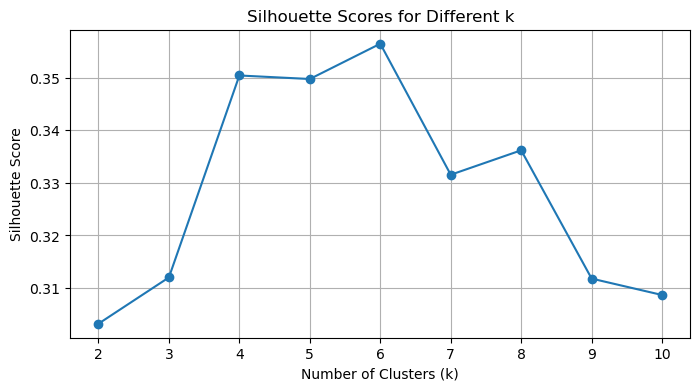

Optimal number of clusters (k) based on silhouette score: 6


In [65]:
silhouette_scores = []
k_range = range(2, 11)  # Try k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df_clustering)
    score = silhouette_score(df_clustering, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Best number of clusters
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (k) based on silhouette score: {best_k}")

In [66]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(df_clustering_subset)

In [67]:
df['Cluster_2'] = cluster_labels

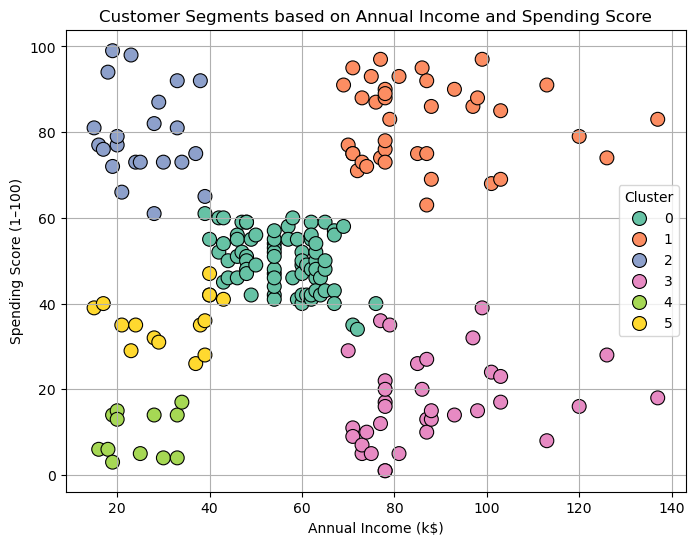

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use unscaled features for easier interpretation in the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster_2',
    palette='Set2',
    s=100,
    edgecolor='k'
)
plt.title('Customer Segments based on Annual Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [72]:
numeric_summary = df.groupby('Cluster_2')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
gender_counts = df.groupby(['Cluster_2', 'Genre'])['CustomerID'].count().unstack().fillna(0)
cluster_summary = numeric_summary.join(gender_counts, how='left')
cluster_summary.columns.name = None 
print(cluster_summary)

                 Age  Annual Income (k$)  Spending Score (1-100)  Female  Male
Cluster_2                                                                     
0          43.194805           56.051948               49.857143      45    32
1          32.692308           86.538462               82.128205      21    18
2          25.272727           25.727273               79.363636      13     9
3          41.114286           88.200000               17.114286      16    19
4          48.750000           24.583333                9.583333       7     5
5          39.266667           31.533333               35.866667      10     5


***Cluster Interpretations:***

Cluster 0: Middle-aged, moderate-income, moderate spenders, slightly more female — Balanced consumers likely representing steady households or professionals. They may respond well to loyalty programs, broad-market promotions, and practical product offerings.

Cluster 1: Young, high-income, high spenders, balanced gender-wise — Your most valuable customers. Likely urban professionals or dual-income millennials. Perfect targets for premium brands, aspirational marketing, and experience-driven campaigns.

Cluster 2: Young, low-income, high spenders, more female — Possibly students or trend-driven early adopters. Despite limited income, they spend heavily, making them ideal for promotions, influencer campaigns, and discount-based engagement.

Cluster 3: Middle-aged, high-income, low spenders, slightly more male — Financially comfortable but conservative buyers. May prioritize trust, value, or long-term benefit. Use rational appeals, testimonials, and proven quality to reach them.

Cluster 4: Older, low-income, very low spenders, more female — Price-sensitive consumers, potentially retired or on fixed income. Most responsive to basic value, senior-targeted messaging, and essential goods.

Cluster 5: Mid-aged, lower-middle income, low-moderate spenders, more female — A cautious but engaged group. May be nurtured into spending more through bundles, referral rewards, and seasonal promotions.
